In [42]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import tqdm as tq

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from torch.utils.data import TensorDataset, DataLoader
from lifelines import WeibullAFTFitter

In [43]:
from models.coDeSurv import ConsistentDeSurv
from models.DeSurv import DeSurv

## Simulating data

In [44]:
train_data = pd.read_csv("../data/posted/sim_train.csv")
test_data = pd.read_csv("../data/posted/sim_test.csv")

In [45]:
d1_data = train_data[train_data.OOD == 0.0]
d2_data = train_data[train_data.OOD == 1.0]

In [46]:
data_ood_test = test_data[test_data.OOD == 1.0]
data_id_test = test_data[test_data.OOD == 0.0]

In [47]:
x_label = ["x1", "x2"]
t_label = "Duration"
e_label = "Censor"
o_label = "OOD"

## Comparison: D1 and D2

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_duration_hist_and_cdf(d1_data: pd.DataFrame, d2_data: pd.DataFrame):
    # Extract 'Duration' columns and sort them for both datasets
    d1_duration = d1_data["Duration"].sort_values()
    d2_duration = d2_data["Duration"].sort_values()

    # Create subplots: 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the histogram on the left subplot
    ax1.hist(
        d1_duration, bins=30, color="red", alpha=0.4, label="D1", edgecolor="black"
    )
    ax1.hist(
        d2_duration, bins=30, color="blue", alpha=0.4, label="D2", edgecolor="black"
    )

    ax1.set_xlabel("Duration")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Histogram of Duration")
    ax1.legend()

    # Compute empirical CDFs
    d1_n = len(d1_duration)
    d2_n = len(d2_duration)

    d1_y_vals = np.arange(1, d1_n + 1) / d1_n
    d2_y_vals = np.arange(1, d2_n + 1) / d2_n

    # Plot the empirical CDF on the right subplot
    ax2.plot(
        d1_duration.values,
        d1_y_vals,
        marker=".",
        linestyle="none",
        color="red",
        label="D1",
    )
    ax2.plot(
        d2_duration.values,
        d2_y_vals,
        marker=".",
        linestyle="none",
        color="blue",
        label="D2",
    )

    ax2.set_xlabel("Duration")
    ax2.set_ylabel("Empirical CDF")
    ax2.set_title("Empirical CDF of Duration")
    ax2.legend()

    # Adjust layout for a cleaner appearance
    plt.tight_layout()

    # Show the plot
    plt.show()

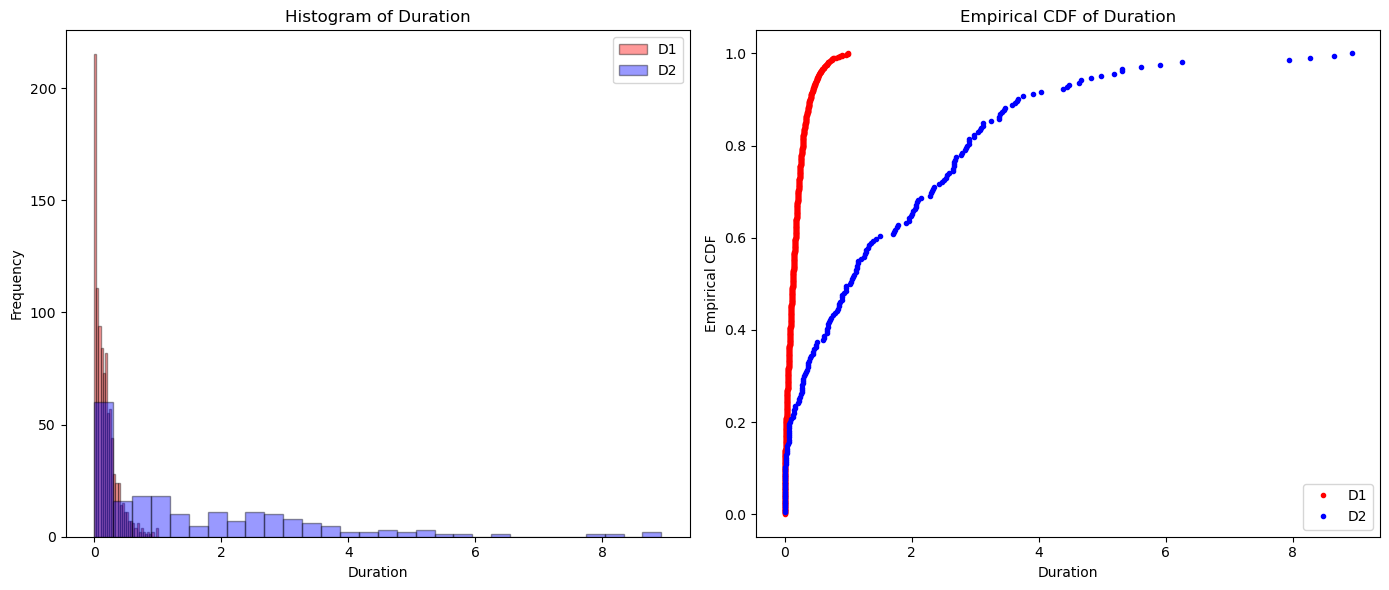

In [49]:
plot_duration_hist_and_cdf(d1_data, d2_data)


## Baseline model: AFT

In [50]:
aft = WeibullAFTFitter()
aft.fit(
    d1_data[[t_label] + [e_label] + x_label],
    duration_col=t_label,
    event_col=e_label,
    show_progress=True,
)

aft.print_summary(3)  # access the results using aft.summary

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.44593387520494593
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.44593387520494593
       x: [ 6.264e-01  7.929e-01 -1.537e+00  2.684e-01]
     nit: 10
     jac: [ 7.343e-08 -5.590e-08  3.572e-08  2.915e-08]
    nfev: 11
    njev: 10


<lifelines.WeibullAFTFitter: fitted with 990 total observations, 298 right-censored observations>
             duration col = 'Duration'
                event col = 'Censor'
   number of observations = 990
number of events observed = 692
           log-likelihood = 441.475
         time fit was run = 2025-03-14 10:29:12 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ x1         0.638     1.893     0.044           0.553           0.724               1.738               2.063
        x2         0.800     2.226     0.042           0.718           0.882               2.051               2.415
        Intercept -1.537     0.215     0.029          -1.594          -1.479               0.203               0.228
rho_    Intercept  0.268     1.308     0.028           0.214           0.323               1.239               1.381

                   cmp to       z       p  -log2(p)
param   covariate                                  
lambda_ x1          0.000  14.628 <0.0005   158.552
        x2          0.000  19.177 <0.0005   269.882
        Intercept   0.000 -52.314 <0.0005       inf
rho_    Intercept   0.000   9.703 <0.0005    71.530
---
Concordance = 0.780
AIC = -874.949
log-likelihood ratio test = 346.449 on 2 df
-log2(p) of ll-ratio test = 249.910

## Evaluation (using training dataset: D1)

In [51]:
tmp = test_data[test_data.OOD == 0.0]

In [52]:
concordance_index_censored(
    tmp["Censor"] == 1.0, tmp["Duration"], -aft.predict_median(tmp)
)

(0.7867016416634737, 26692, 7237, 0, 0)

## Define necessary UDF

In [53]:
def split_dataframe(df, train_size=0.8, val_size=0.2, random_state=None):
    """
    Splits the DataFrame into train, validation, and test sets.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    train_size (float): Proportion of the data to be used for the training set.
    val_size (float): Proportion of the data to be used for the validation set.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: A tuple containing the train, validation, and test DataFrames.
    """
    assert train_size + val_size == 1, "Proportions must sum to 1."

    # Split the DataFrame into train and remaining sets
    df_train, df_val = train_test_split(
        df, train_size=train_size, random_state=random_state
    )

    return df_train, df_val

In [54]:
def split_df(df, x_label, t_label, e_label, o_label):
    return (
        df[x_label].values,
        df[t_label].values,
        df[e_label].values,
        df[o_label].values,
    )

In [55]:
def predict_cif(method, df):
    x_cov = torch.tensor(df[x_label].values, dtype=torch.float32)
    t = torch.tensor(df[t_label].values, dtype=torch.float32)

    cif = method.predict(x_cov, t)

    return cif

In [56]:
def compute_timediff(model, data_loader_val, n_sample, df_type, verbose):
    if df_type == "D1":
        idx_in = 1.0
        idx_ood = 0.0
    else:
        idx_in = 0.0
        idx_ood = 1.0

    reg_loss = 0
    for batch_idx, (x, t, k, o) in tq.tqdm(enumerate(data_loader_val)):
        argsort_t = torch.argsort(t)
        x_ = x[argsort_t, :].to(model.device)
        o_ = o[argsort_t].to(model.device)

        x_ood = x_[o_ == idx_ood]

        regloss = 0.0
        if x_ood.shape[0] > 0:
            _, regloss_ = model.regularisation(
                x=x_ood, verbose=verbose, n_sample=n_sample
            )
            regloss = regloss_.item()

        reg_loss += regloss

    return reg_loss

## coDeSurv: DeSurv with consistency constraint.

Data preparation step includes:
1. Split training data (i.e. D1 and D2) into train and validation set
2. Apply likelihood-based training w.r.t. D1 while regularising the model using the baseline based on D2.
3. Generate test set (D1 and D2) using the data generating process and use them for the final evaluation

First, we create train_data by combining the D1 and D2 generated above. Recall that we require indicator for the source of data (i.e., out-of-distribution / in-distribution) to determine which objective function to optimise depending on the source of D1 data will be used for consistency regularsation whereas the D2 data will be used for likelihood term. Note that the baseline model was trained on D2 and tested on D1. 

In [57]:
df_train, df_val = split_dataframe(train_data)

In [58]:
x_train, t_train, e_train, o_train = split_df(
    df_train, x_label, t_label, e_label, o_label
)
x_val, t_val, e_val, o_val = split_df(df_val, x_label, t_label, e_label, o_label)

In [59]:
batch_size = 128

In [60]:
dataset_train = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_train, torch.float32),
            (t_train, torch.float32),
            (e_train, torch.long),
            (o_train, torch.long),
        ]
    ]
)
data_loader_train = DataLoader(
    dataset_train, batch_size=batch_size, pin_memory=True, shuffle=True, drop_last=True
)

dataset_val = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_val, torch.float32),
            (t_val, torch.float32),
            (e_val, torch.long),
            (o_val, torch.long),
        ]
    ]
)
data_loader_val = DataLoader(
    dataset_val, batch_size=batch_size, pin_memory=True, shuffle=True
)

In this section, we train the model. During training, you might encounter error messages such as “Error occurred with tensor([0.9990]). Retrying…”. This error indicates that the numerical solver, which is required during the sampling step from the predicted survival time CDF, fails to converge because the simulated failure time is very close to 1. When this occurs, we simply re-sample the survival time from the CDF.

Note: it seems that this error can occur for the value not close to 1 as well. It would be important to investigate why this happens, and figure out how to make this operation more robust.

In [61]:
hidden_dim = 8
training = False
lr = 1e-3
n_epochs = 300

xdim = x_train.shape[1]

In [62]:
codesurv = ConsistentDeSurv(
    lr,
    xdim,
    hidden_dim,
    baseline=aft,
    nonlinearity=nn.ReLU,
    device="cpu",
    n=15,
    df_columns=x_label,
)

if training:
    codesurv.optimize(
        data_loader_train,
        n_sample=50,
        n_epochs=n_epochs,
        logging_freq=1,
        data_loader_val=data_loader_val,
        max_wait=20,
        pretrain_epochs=20,
        verbose=True,
    )
    torch.save(codesurv.state_dict(), "model_state/codesurv_sim")
    codesurv.eval()
else:
    state_dict = torch.load("model_state/codesurv_sim")
    codesurv.load_state_dict(state_dict)
    codesurv.eval()

CondODENet: cpu specified, cpu used


## D1_DeSurv: Train DeSurv using only D1

In [63]:
df_train_d1, df_val_d1 = split_dataframe(d1_data)

In [64]:
x_train_d1, t_train_d1, e_train_d1, o_train_d1 = split_df(
    df_train_d1, x_label, t_label, e_label, o_label
)
x_val_d1, t_val_d1, e_val_d1, o_val_d1 = split_df(
    df_val_d1, x_label, t_label, e_label, o_label
)

In [65]:
batch_size = 128

In [66]:
dataset_train_d1 = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_train_d1, torch.float32),
            (t_train_d1, torch.float32),
            (e_train_d1, torch.long),
            (o_train_d1, torch.long),
        ]
    ]
)
data_loader_train_d1 = DataLoader(
    dataset_train_d1,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
)

dataset_val_d1 = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_val_d1, torch.float32),
            (t_val_d1, torch.float32),
            (e_val_d1, torch.long),
            (o_val_d1, torch.long),
        ]
    ]
)
data_loader_val_d1 = DataLoader(
    dataset_val_d1, batch_size=batch_size, pin_memory=True, shuffle=True
)

In [67]:
desurv = DeSurv(
    lr,
    xdim,
    hidden_dim,
    baseline=aft,
    nonlinearity=nn.ReLU,
    device="cpu",
    n=15,
    df_columns=x_label,
)

if training:
    desurv.optimize(
        data_loader_train_d1,
        n_sample=50,
        n_epochs=n_epochs,
        logging_freq=1,
        data_loader_val=data_loader_val_d1,
        max_wait=20,
    )
    torch.save(desurv.state_dict(), "model_state/desurv_sim")
    desurv.eval()
else:
    state_dict = torch.load("model_state/desurv_sim")
    desurv.load_state_dict(state_dict)
    desurv.eval()

CondODENet: cpu specified, cpu used


## Evaluation

1. C-index
2. Log-likelihood
3. Expected discrepancy between survival trajectories

### Prepare test set

In [68]:
x_test, t_test, e_test, o_test = split_df(test_data, x_label, t_label, e_label, o_label)

dataset_test = TensorDataset(
    *[
        torch.tensor(u, dtype=dtype_)
        for u, dtype_ in [
            (x_test, torch.float32),
            (t_test, torch.float32),
            (e_test, torch.long),
            (o_test, torch.long),
        ]
    ]
)

data_loader_test = DataLoader(
    dataset_test, batch_size=batch_size, pin_memory=True, shuffle=True
)

## Quantitative Assessment

In [69]:
loss_v1_d1 = compute_timediff(
    codesurv, data_loader_test, n_sample=50, df_type="D1", verbose=True
)

0it [00:00, ?it/s]

In [ ]:
loss_v2_d1 = compute_timediff(
    desurv, data_loader_test, n_sample=50, df_type="D1", verbose=True
)

In [ ]:
print("Similarity across survival trajectories")
print("Dataset: D1")
print(f"coDeSurv: {loss_v1_d1}, DeSurv (D1): {loss_v2_d1}")

In [ ]:
loss_v1_d2 = compute_timediff(
    codesurv, data_loader_test, n_sample=50, df_type="D2", verbose=True
)

In [ ]:
loss_v2_d2 = compute_timediff(
    desurv, data_loader_test, n_sample=50, df_type="D2", verbose=True
)

In [ ]:
loss_v2_d2

In [ ]:
print("Similarity across survival trajectories")
print("Dataset: D2")
print(f"coDeSurv: {loss_v1_d2}, DeSurv (D1): {loss_v2_d2}")

### Multiple iterations over consistency metrics

In [ ]:
models = {"coDeSurv": defaultdict(list), "DeSurv": defaultdict(list)}
iterations = 100

In [ ]:
for i in tq.tqdm(range(iterations)):
    print(f"Iteration: {i}")
    for data_type in ["D1", "D2"]:
        print(f"Iteration: {i} - coDeSurv - Computing the metric on {data_type}")
        models["coDeSurv"][f"consistency_{data_type}"].append(
            compute_timediff(
                codesurv, data_loader_test, n_sample=50, df_type=data_type, verbose=True
            )
        )

        print(f"Iteration: {i} - D1_DeSurv - Computing the metric on {data_type}")
        models["DeSurv"][f"consistency_{data_type}"].append(
            compute_timediff(
                desurv, data_loader_test, n_sample=50, df_type=data_type, verbose=True
            )
        )

In [ ]:
for k, v in models.items():
    for key, value in v.items():
        print(f"{k} - {key}")
        print(np.round(np.mean(value[:50]), 4), np.round(np.std(value[:50]), 4))

## Predictive accuracy

We first fix the dataset to be used for the evaluation. This is to ensure that we use the same dataset to compare both similarity and predictive accuracy of each model.

In [ ]:
lik_v1 = desurv.compute_lik(
    data_id_test[x_label].values,
    data_id_test[t_label].values,
    data_id_test[e_label].values,
)
lik_v1_d2 = desurv.compute_lik(
    data_ood_test[x_label].values,
    data_ood_test[t_label].values,
    data_ood_test[e_label].values,
)

lik_v2 = codesurv.compute_lik(
    data_id_test[x_label].values,
    data_id_test[t_label].values,
    data_id_test[e_label].values,
)
lik_v2_d2 = codesurv.compute_lik(
    data_ood_test[x_label].values,
    data_ood_test[t_label].values,
    data_ood_test[e_label].values,
)

In [ ]:
print("Predictive accuracy: log-likelihood")
print("Dataset: D1")
print(f"D1: Consistent DeSurv: {lik_v1}, DeSurv (D1): {lik_v2}")

In [ ]:
print("Predictive accuracy: log-likelihood")
print("Dataset: D2")
print(f"D1: Consistent DeSurv: {lik_v1_d2}, DeSurv (D1): {lik_v2_d2}")

In [ ]:
(
    aft.score(data_id_test[[t_label] + [e_label] + x_label]),
    aft.score(data_ood_test[[t_label] + [e_label] + x_label]),
)

## C-index

In [ ]:
def compute_cidx(model_name, df):
    res = 0
    if model_name == "baseline":
        res = concordance_index_censored(
            df["Censor"] == 1.0, df["Duration"], -aft.predict_median(df)
        )

    elif model_name == "coDeSurv":
        res = concordance_index_censored(
            df["Censor"] == 1.0,
            df["Duration"],
            -predict_cif(codesurv, df).detach().numpy(),
        )
    elif model_name == "DeSurv":
        res = concordance_index_censored(
            df["Censor"] == 1.0,
            df["Duration"],
            -predict_cif(desurv, df).detach().numpy(),
        )

    return res

In [ ]:
def show_cidx(model_name):
    cidx_d1, cidx_d2 = (
        compute_cidx(model_name, data_id_test),
        compute_cidx(model_name, data_ood_test),
    )

    print(f"{model_name}")
    print(f"D1: {cidx_d1[0]}, D2: {cidx_d2[0]} \n")

In [ ]:
print("Predictive accuracy: c-index")

for model_name in ["baseline", "coDeSurv", "DeSurv"]:
    show_cidx(model_name)

## Qualitative Assessment: visualise the predicted survival curves across different models

In [ ]:
def gather_predictions(df, method):
    baseline_surv = aft.predict_survival_function(df, times=np.linspace(0, 2, 200))
    surv = method.predict_surv_df(
        torch.tensor(df[x_label].values, dtype=torch.float32).clone().detach(),
        np.linspace(0, 2, 200),
    )

    return baseline_surv, surv


def plot_surv(baseline_surv, surv, df, idx, model_name="DeSurv"):
    plt.plot(surv.iloc[:, idx], label=model_name)
    plt.plot(baseline_surv.iloc[:, idx], color="grey", label="Baseline")

    #     plt.axvline(df["Duration"].iloc[idx], label = "Censor: %d" % df["Censor"].iloc[idx], color = 'black')
    plt.legend()
    plt.xlabel("Durations")
    plt.ylabel("Survival Probabilities")
    plt.show()


def plot_surv_joint(baseline_surv, joint_survs, df, idx, figsize=(8, 5)):
    plt.figure(figsize=figsize)
    colors = sns.color_palette("hls", len(joint_survs))
    for i, (model_name, model) in enumerate(joint_survs.items()):
        plt.plot(model.iloc[:, idx], color=colors[i], label=model_name)

    plt.plot(baseline_surv.iloc[:, idx], color="grey", label="Baseline")

    #     plt.axvline(df["Duration"].iloc[idx], label = "Censor: %d" % df["Censor"].iloc[idx], color = 'black')
    plt.legend()
    plt.xlabel("Durations")
    plt.ylabel("Survival Probabilities")
    # plt.savefig("images/traj_simulated", dpi=400)
    plt.show()

In [ ]:
d1_baseline_surv, d1_surv = gather_predictions(d1_data, desurv)
d1_baseline_surv_v2, d1_surv_v2 = gather_predictions(d1_data, codesurv)

In [ ]:
d1_joint_surv = {"coDeSurv": d1_surv_v2, "d1_DeSurv": d1_surv}

In [ ]:
d2_baseline_surv, d2_surv = gather_predictions(d2_data, desurv)
d2_baseline_surv_v2, d2_surv_v2 = gather_predictions(d2_data, codesurv)

In [ ]:
d2_joint_surv = {"coDeSurv": d2_surv_v2, "d1_DeSurv": d2_surv}

In [ ]:
plot_surv_joint(d1_baseline_surv, d1_joint_surv, d1_data, 5)

In [ ]:
plot_surv_joint(d2_baseline_surv, d2_joint_surv, d2_data, 3)

In [ ]:
plot_surv_joint(d2_baseline_surv, d2_joint_surv, data_ood_test, 21)